In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
pip install lightgbm

     ---------------------------------------- 1.4/1.4 MB 367.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
df=pd.read_csv("nutrients_csvfile.csv")

In [30]:
df.sample(10)

,Food,Measure,Grams,Calories,Protein,Fat,Sat.Fat,Fiber,Carbs,Category,protein_to_fat_ratio,carbs_to_fat_ratio
20,NaN,2.0,17.0,70.0,4.0,6.000,5.0,0.0,0.001,NaN,0.666667,0.000167
161,NaN,2.0,50.0,9.0,1.0,0.001,0.0,0.3,1.000,NaN,1000.000000,1000.000000
299,NaN,2.0,135.0,330.0,3.0,13.000,11.0,0.1,53.000,NaN,0.230769,4.076923
257,NaN,2.0,250.0,217.0,4.0,4.000,0.0,1.2,40.000,NaN,1.000000,10.000000
156,NaN,2.0,150.0,30.0,1.0,0.001,0.0,0.6,6.000,NaN,1000.000000,6000.000000
63,NaN,2.0,100.0,260.0,16.0,21.000,18.0,0.0,0.000,NaN,0.761905,0.000000
270,NaN,2.0,250.0,115.0,6.0,4.000,3.0,0.2,13.000,NaN,1.500000,3.250000
249,NaN,2.0,191.0,692.0,14.0,0.001,0.0,0.3,150.000,NaN,14000.000000,150000.000000
322,NaN,2.0,50.0,325.0,7.0,32.000,7.0,1.0,8.000,NaN,0.218750,0.250000
197,NaN,2.0,200.0,75.0,1.0,0.001,0.0,1.8,18.000,NaN,1000.000000,18000.000000


In [4]:
df.isnull().sum()

Food        0
Measure     0
Grams       0
Calories    1
Protein     0
Fat         0
Sat.Fat     2
Fiber       0
Carbs       0
Category    0
dtype: int64

In [31]:
df.dtypes

Food                    float64
Measure                 float64
Grams                   float64
Calories                float64
Protein                 float64
Fat                     float64
Sat.Fat                 float64
Fiber                   float64
Carbs                   float64
Category                float64
protein_to_fat_ratio    float64
carbs_to_fat_ratio      float64
dtype: object

In [32]:
# Displaying unique values in each column to check for 't'
for column in df.columns:
    print(f"Unique values in {column}: {df[column].unique()}")

Unique values in Food: [nan]
Unique values in Measure: [ 2.  5.  8.  4.  1. 10.  3.]
Unique values in Grams: [976. 984. 246. 252. 108. 103.  85. 244. 540. 250. 248. 188. 190. 120.
 119. 225.  17.  56.  28. 100. 128.  34.  14. 112. 110.  15.  60.  16.
 227. 235. 115.  86.  57. 230.  96. 125. 160. 192. 200. 260.  50. 165.
 150. 130. 170.  40. 180. 140. 210. 155.  38.  20. 175. 240. 145.  75.
 114. 144. 380. 257. 277. 178.  42. 256. 285. 153. 220. 218.  65. 255.
 182. 122. 270.  88. 149. 925.  25.  23. 454. 242. 118.  11. 238.  48.
 236. 208. 187. 191.  30.  68. 245.  55.  90.  33. 239. 300. 135.  12.
  70.  52. 480. 346.]
Unique values in Calories: [660. 360. 127. 345. 130. 515. 290. 165. 690. 235. 128. 275. 285. 300.
 170. 430. 240. 195.  70. 226. 105. 150. 220. 120. 100. 113. 665. 992.
 806. 110. 125.  60.  75. 470.  95. 245. 185. 390. 330. 115. 480. 140.
 370. 314. 260. 310. 475. 265. 305.  87.  90. 200. 135. 182. 211.  92.
 155. 231. 180. 104.  18.  25. 250. 230.  17.  27.   1.  45. 

In [29]:
# Replacing 't' with a small numeric value (e.g., 0.001)
df = df.replace('t', 0)

In [8]:
df = df.apply(pd.to_numeric, errors='coerce')


In [33]:
if df.isna().sum().sum() > 0:
    df = df.fillna(df.median())

In [34]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(df.median())

In [35]:
assert not np.isinf(df).values.any(), "Dataset contains inf values after cleaning."

In [36]:
# creating new features
df['protein_to_fat_ratio'] = df['Protein'] / df['Fat']
df['carbs_to_fat_ratio'] = df['Carbs'] / df['Fat']

In [37]:
X = df.drop('Calories', axis=1)
y = df['Calories']

In [38]:
categorical_features = X.select_dtypes(include=['object']).columns

In [39]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_cats = encoder.fit_transform(X[categorical_features])
encoded_cat_df = pd.DataFrame(encoded_cats.toarray(), columns=encoder.get_feature_names_out(categorical_features))

In [40]:
print(f"Final dataset shape after preprocessing: {X.shape}")

Final dataset shape after preprocessing: (335, 11)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
model = lgb.LGBMRegressor(random_state=42)

In [49]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [50]:
# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=50, cv=5, verbose=2, n_jobs=-1, random_state=42, error_score='raise')
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 268, number of used features: 8
[LightGBM] [Info] Start training from score 175.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=LGBMRegressor(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, verbose=2)

In [51]:
best_model = random_search.best_estimator_

In [52]:
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 268, number of used features: 8
[LightGBM] [Info] Start training from score 159.354478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [53]:
print(f"Cross-Validation RMSE: {cv_rmse.mean()} ± {cv_rmse.std()}")

Cross-Validation RMSE: 93.3100253863058 ± 41.317634963432305


In [54]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 268, number of used features: 8
[LightGBM] [Info] Start training from score 175.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [55]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [57]:
# Feature importance visualization
feature_importances = best_model.feature_importances_
features = X.columns

In [58]:
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

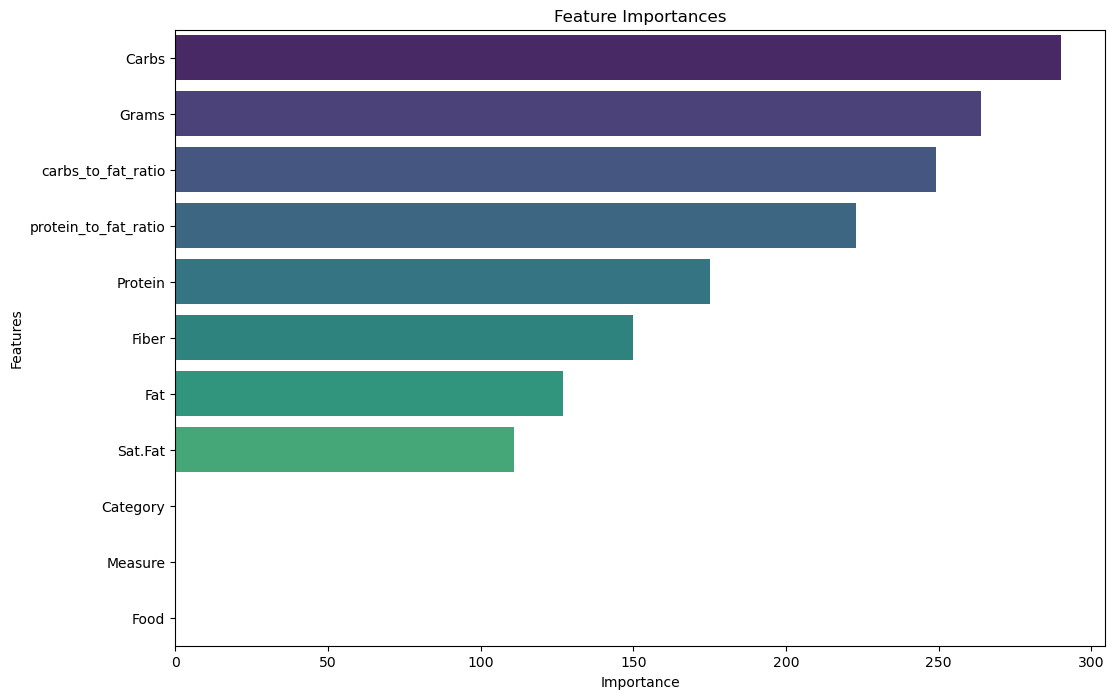

In [64]:
indices = np.argsort(feature_importances)[::-1]
sorted_features = [features[i] for i in indices]
sorted_importances = feature_importances[indices]
# Plotting the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_importances, y=sorted_features, palette="viridis")
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

C:\Users\mdipa\AppData\Local\Temp\ipykernel_12416\1277516454.py:3: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(y=sorted_importances, x=sorted_features, palette="viridis")


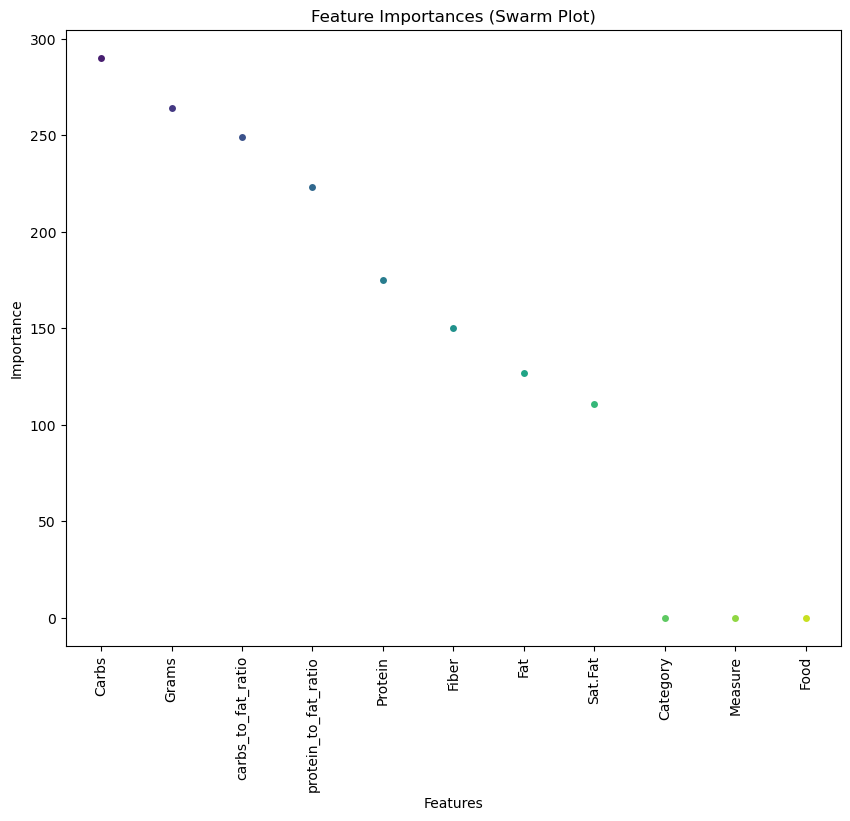

In [66]:
# Creating swarm plot of feature importances
plt.figure(figsize=(10, 8))
sns.swarmplot(y=sorted_importances, x=sorted_features, palette="viridis")
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances (Swarm Plot)')
plt.xticks(rotation=90)
plt.show()